In [1]:
import sqlite3
import enum
from functools import total_ordering

FIG_PATH = "/home/tim/Projects/bachelor-thesis/figs/"
DB_PATH = "/home/tim/idintfw.db"

con = sqlite3.connect(DB_PATH)
c = con.cursor()
rows = c.execute("SELECT * FROM Runs LEFT JOIN Errors ON Runs.ID=Errors.Run")

class App:
    def __init__(self, name, sources, sinks, classes, methods, statements, cgsize):
        self.name = name
        self.sources = sources
        self.sinks = sinks
        self.classes=classes
        self.methods=methods
        self.statements=statements
        self.cgsize=cgsize
        self.runs = []
        self.runsSMP = []
        self.fwRuns = []
        self.bwRuns = []
        self.fwsmpRuns = []
        self.bwsmpRuns = []
        
    def addRun(self, run):
        if run.direction == Direction.Forwards:
            self.fwRuns.append(run)
        elif run.direction == Direction.Backwards:
            self.bwRuns.append(run)
        elif run.direction == Direction.ForwardsSMP:
            self.fwsmpRuns.append(run)
        elif run.direction == Direction.BackwardsSMP:
            self.bwsmpRuns.append(run)
    
    def isTimeValid(self):
        return len(self.runs) == 2
    def isMemValid(self):
        return len(self.runsSMP) == 2
            
    def timeMedian(self, src, dst):
        if 0 < len(src) < 3:
            print("ERROR: Only %s time-runs for %s!" % (len(src), self.name))

        if len(src) != 3:
            return
        
        src.sort()
        if src[1].dataflowTime != 0:
            relDiff = abs(src[0].dataflowTime - src[1].dataflowTime) / abs(src[1].dataflowTime)
            absDiff = src[1].dataflowTime-src[0].dataflowTime
            if relDiff > 0.5 and absDiff > 5:
                print("FML0 %s for %s" % (src[0].ID, src[0].runID))
            relDiff = (src[2].dataflowTime - src[1].dataflowTime) / abs(src[1].dataflowTime)
            absDiff = src[2].dataflowTime-src[1].dataflowTime
            if relDiff > 0.5 and absDiff > 5:
                print("FML2 %s for %s" % (src[2].ID, src[2].runID))
        dst.append(src[1])
        src.clear()
        
#     def memMedian(self, src, dest):
#         if 0 < len(src) < 3:
#             print("ERROR: Only %s mem-runs for %s!" % (len(src), self.name))

#         if len(src) != 3:
#             return
        
#         src.sort(key=lambda x: x.maxMemPrecise)
#         if src[1].maxMemPrecise != 0:
#             relDiff = abs(src[0].maxMemPrecise - src[1].maxMemPrecise) / abs(src[1].maxMemPrecise)
#             if relDiff > 0.75:
#                 print("MEMFML0 %s for %s" % (src[0].ID, src[0].runID))
#             relDiff = (src[2].maxMemPrecise - src[1].maxMemPrecise) / abs(src[1].maxMemPrecise)
#             if abs(relDiff) > 0.75:
#                 print("MEMFML2 %s for %s" % (src[2].ID, src[2].runID))
#         dest.append(src[1])
#         src.clear()
    
    def selectMedian(self):
        self.timeMedian(self.fwsmpRuns, self.runsSMP)
        self.timeMedian(self.bwsmpRuns, self.runsSMP)
        self.timeMedian(self.fwRuns, self.runs)
        self.timeMedian(self.bwRuns, self.runs)

class Direction(enum.Enum):
    Forwards = 0
    Backwards = 1
    ForwardsSMP = 2
    BackwardsSMP = 3
    
@total_ordering
class TimeRun:
    def __init__(self, ID, direction, maxMem, infoflowEdges, aliasEdges, timeElapsed, dataflowTime, 
                 leaks, terminationState, absCountInfoflow, absCountAlias, runID, avgMemInfo, avgMemAlias,
                 finalMemInfo, finalMemAlias):
        if direction == "FastSolverfw":
            self.direction = Direction.Forwards
        elif direction == "FastSolverbw":
            self.direction = Direction.Backwards
        elif direction == "FastSolverfw_smp":
            self.direction = Direction.ForwardsSMP
        elif direction == "FastSolverbw_smp":
            self.direction = Direction.BackwardsSMP
        else:
            print("ERROR: Unknown direction!")
        self.ID = ID
        self.maxMem = maxMem
        self.infoflowEdges = infoflowEdges
        self.aliasEdges = aliasEdges
        self.timeElapsed = timeElapsed
        self.dataflowTime = dataflowTime
        self.leaks = leaks
        self.absCountInfoflow = absCountInfoflow
        self.absCountAlias = absCountAlias
        self.memoryTimeout = terminationState == 2 
        self.timeTimeout = terminationState == 1 and dataflowTime > 599
        self.runID = runID
        self.avgMemInfo = avgMemInfo
        self.avgMemAlias = avgMemAlias
        self.avgMem = (self.avgMemInfo + self.avgMemAlias) / 2.0
        self.finalMemInfo = finalMemInfo
        self.finalMemAlias = finalMemAlias
        self.maxMemPrecise = self.finalMemInfo + self.finalMemAlias
        
    def __lt__(self, other):
        return self.dataflowTime < other.dataflowTime

        
apps = {}
for row in rows:
    name = row[1]
    
    if not name in apps:
        apps[name] = App(name, row[16], row[17], row[18], row[19], row[20], row[21])

    # no need to add Runs which
    # did not start
    # had no sinks, thus -1 time
    # with exception thrown
    if row[6] == None or row[6] == -1 or row[26] != None or row[10] == 0:
        continue
    # only verify source sink manager when analysis started
    app = apps[name]
    if row[16] != app.sources:
        # print("Sources differ for %s: %s to %s" % (name, app.sources, row[16]))
        continue
    if row[17] != app.sinks:
        # print("Sinks differ for %s: %s to %s" % (name, app.sinks, row[17]))
        continue

    # ignore run 0
    if row[25] > 0:
        app.addRun(TimeRun(row[0], row[2], row[7], row[22], row[23], row[5], row[6], row[14], 
                           row[15], row[12], row[13], row[25], row[8], row[9], row[10], row[11]))
    
for app in apps.values():
    app.selectMedian()

def runToColor(run):
    if run.memoryTimeout:
        return "#d62728"
    elif run.timeTimeout:
        return "#ff7f0e"
    else:
        return "#1f77b4"
    
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pylatex.utils import escape_latex 

matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    "pgf.preamble": [
        r'\usepackage{amsmath}'
    ],
    'font.family': 'sans-serif',
    'font.sans-serif': ['Roboto'],
    'text.usetex': True,
    'pgf.rcfonts': False,
})


FML2 2674 for 3
FML2 2120 for 3
FML2 2321 for 1
FML0 2328 for 1
FML2 2013 for 2
FML0 3096 for 3
FML0 2790 for 3
FML2 3082 for 1
FML2 2805 for 3


-108.7089552238806
134


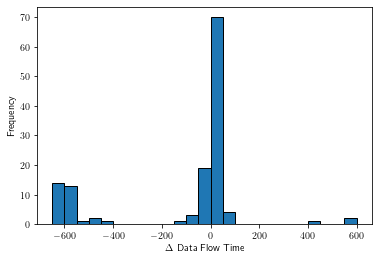

In [2]:
# Delta of each app

xfw = []
datafw = []
cfw = []
xbw = []
databw = []
cbw = []

delta = []
for name, app in apps.items():
    if not app.isTimeValid():
        continue
        
    leaks = -1
    d = 0
       
    r1 = None
    r2 = None
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xfw.append(escape_latex(name))
            cfw.append(runToColor(run))
            d -= run.dataflowTime
            r1 = run
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            xbw.append(escape_latex(name))
            cbw.append(runToColor(run))
            d += run.dataflowTime
            r2 = run
#         if leaks == -1:
#             leaks = run.leaks
#         elif leaks != run.leaks:
#             print(f"Leaks differ for {name}: {leaks} vs {run.leaks}")
            
    if abs(d) > 399:
        rel = app.sources / app.sinks
        if d < 0:
            ed1 = round(r1.infoflowEdges / r2.infoflowEdges)
            ed2 = round(r1.aliasEdges / r2.aliasEdges)
        else:
            ed1 = round(r2.infoflowEdges / (1 if r1.infoflowEdges == 0 else r1.infoflowEdges))
            ed2 = round(r2.aliasEdges / (1 if r1.aliasEdges == 0 else r1.aliasEdges))
#         print(f"{name}: {d}s with {app.sources}:{app.sinks} and edge {ed1}:{ed2}")
    delta.append(d)

        
print(sum(delta)/len(xfw))
print(len(xfw))

fig = plt.figure()
base = 50
rounded = int(base * np.ceil(np.abs(delta).max()/base))
plt.hist(delta, bins=np.arange(-rounded, rounded, base), edgecolor='black')
plt.xlabel("$\\Delta$ Data Flow Time")
plt.ylabel("Frequency")
plt.savefig(FIG_PATH + "deltaHist.pgf")

# fig = plt.figure(figsize=(20, 5))
# ax = fig.add_subplot(111)
# ind = np.arange(len(xfw))
# width = 0.2
# ax.bar(ind, delta, width)
# ax.bar(ind - width/2, datafw, width, color=cfw)
# ax.bar(ind + width/2, databw, width, color=cbw)
# ax.set_xticklabels(xfw)
# plt.xticks(ind)
# ax.set_ylabel("$\\Delta$ Dataflow Time")
# _ = plt.xticks(rotation=90)
# plt.savefig(FIG_PATH + "dataflowDelta.pgf")

0.9302297906449848
0.9757099053086192
0.9126358525587691
0.9347429156210513
0.9342413526890551
0.935111696706161


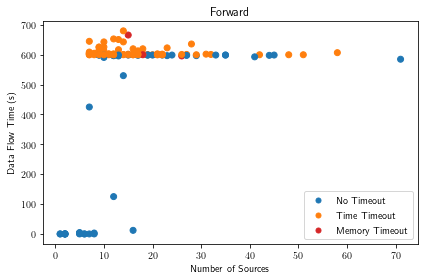

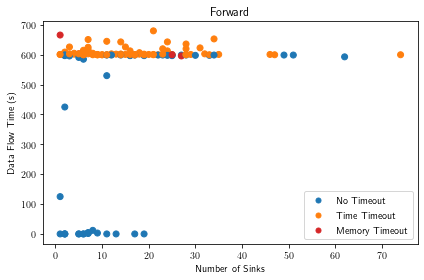

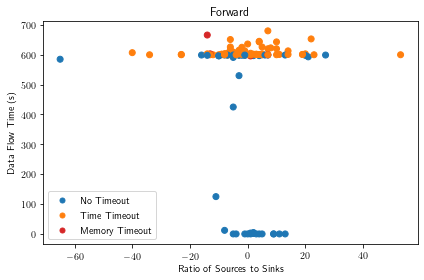

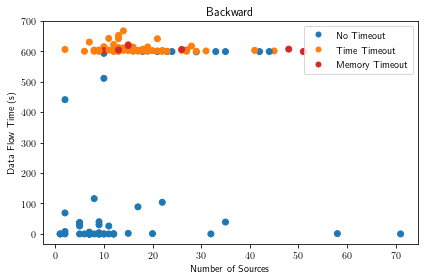

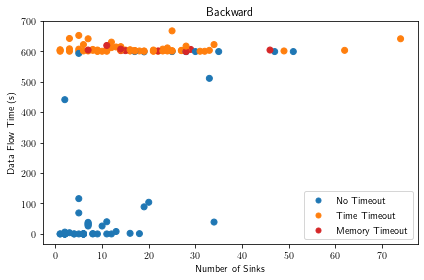

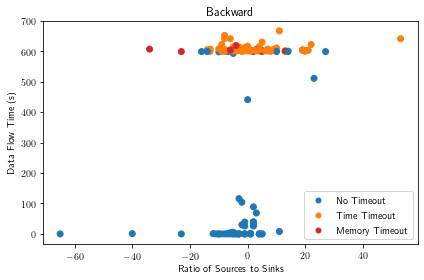

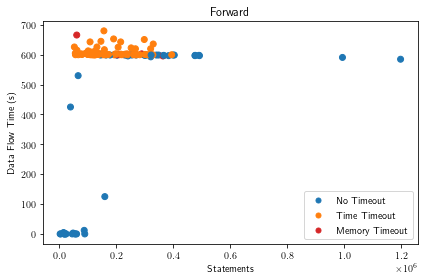

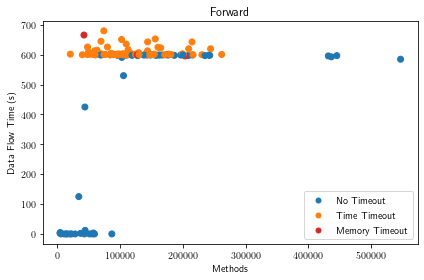

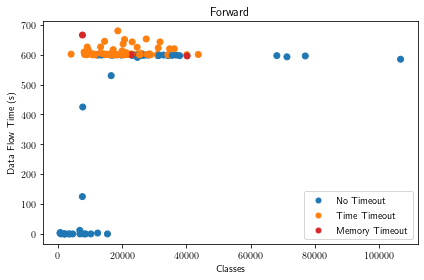

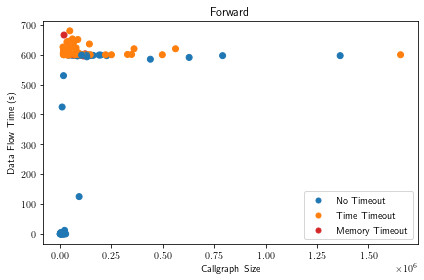

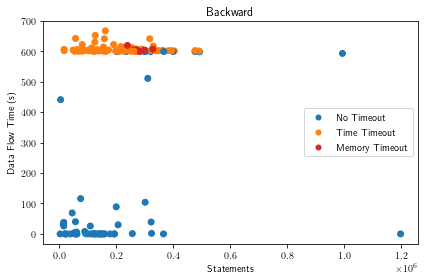

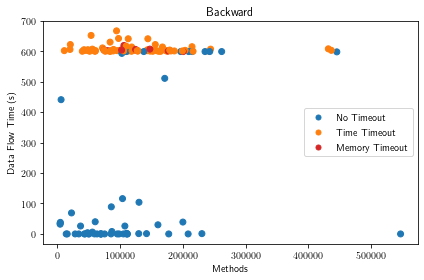

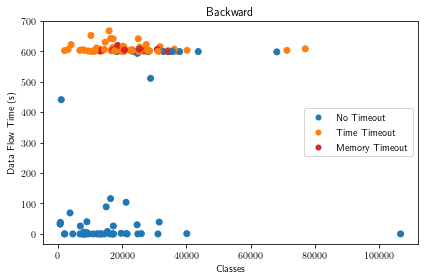

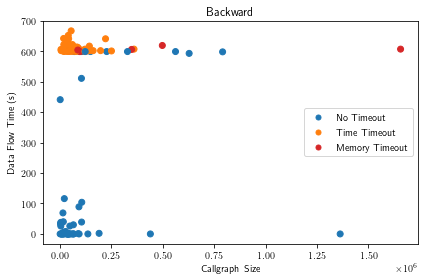

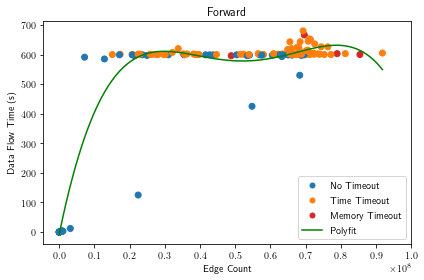

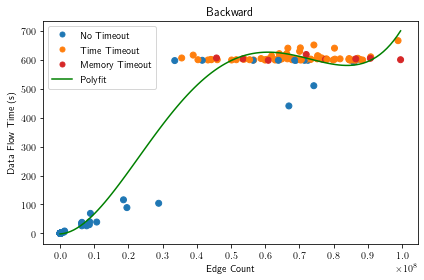

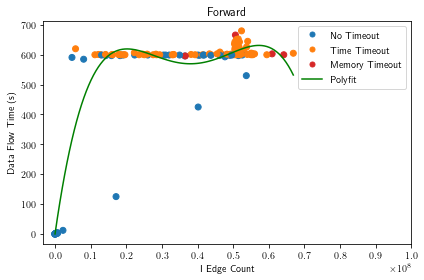

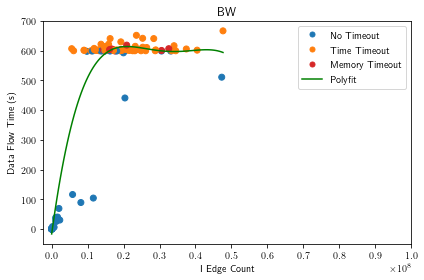

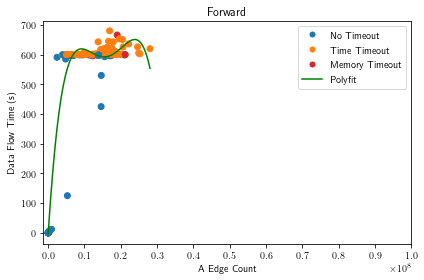

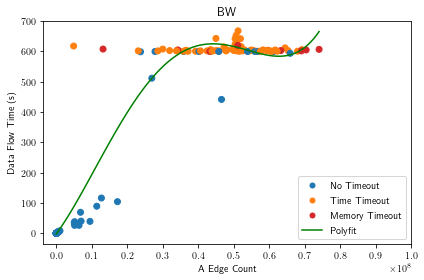

In [12]:
# Per Sources/Sinks
blue_dot = mlines.Line2D([], [], color='#1f77b4', marker='.', linestyle='None',
                          markersize=10, label='No Timeout')
orange_dot = mlines.Line2D([], [], color='#ff7f0e', marker='.', linestyle='None',
                          markersize=10, label='Time Timeout')
red_dot = mlines.Line2D([], [], color='#d62728', marker='.', linestyle='None',
                          markersize=10, label='Memory Timeout')
green_line = mlines.Line2D([], [], color='g',
                          markersize=10, label='Polyfit')
handles = [blue_dot, orange_dot, red_dot]
handles2 = [blue_dot, orange_dot, red_dot, green_line]

from scipy import stats
from sklearn.metrics import r2_score

xsources = []
xsinks = []
xratio = []
xstmts = []
xclasses = []
xmethods = []
xcg = []
xedgesfw = [[],[]]
xedgesbw = [[],[]]
xpropfw = []
xpropbw = []
datafw = []
cfw = []
databw = []
cbw = []
for name, app in apps.items():
    if not app.isTimeValid():
        continue
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xsources.append(app.sources)
            xsinks.append(app.sinks)
            xratio.append(app.sinks - app.sources)
            xstmts.append(app.statements)
            xclasses.append(app.classes)
            xmethods.append(app.methods)
            xcg.append(app.cgsize)
            xedgesfw[0].append(run.absCountInfoflow)
            xedgesfw[1].append(run.absCountAlias)
            cfw.append(runToColor(run))
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            cbw.append(runToColor(run))
            xedgesbw[0].append(run.absCountInfoflow)
            xedgesbw[1].append(run.absCountAlias)



plt.figure()
plt.scatter(xsources, datafw, c=cfw)
plt.xlabel("Number of Sources")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-sources.pgf")       
plt.figure()
plt.scatter(xsinks, datafw, c=cfw)
plt.xlabel("Number of Sinks")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-sinks.pgf")
plt.figure()
plt.scatter(xratio, datafw, c=cfw)
plt.xlabel("Ratio of Sources to Sinks")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-ssratio.pgf")       


plt.figure()
plt.scatter(xsources, databw, c=cbw)
plt.xlabel("Number of Sources")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-sources.pgf")
plt.figure()
plt.scatter(xsinks, databw, c=cbw)
plt.xlabel("Number of Sinks")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-sinks.pgf")
plt.figure()
plt.scatter(xratio, databw, c=cbw)
plt.xlabel("Ratio of Sources to Sinks")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-ssratio.pgf")

plt.figure()
plt.scatter(xstmts, datafw, c=cfw)
plt.xlabel("Statements")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-statements.pgf")
plt.figure()
plt.scatter(xmethods, datafw, c=cfw)
plt.xlabel("Methods")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-methods.pgf")
plt.figure()
plt.scatter(xclasses, datafw, c=cfw)
plt.xlabel("Classes")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-classes.pgf")
plt.figure()
plt.scatter(xcg, datafw, c=cfw)
plt.xlabel("Callgraph Size")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-cg.pgf")
plt.figure()
plt.scatter(xstmts, databw, c=cbw)
plt.xlabel("Statements")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-statements.pgf")
plt.figure()
plt.scatter(xmethods, databw, c=cbw)
plt.xlabel("Methods")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-methods.pgf")
plt.figure()
plt.scatter(xclasses, databw, c=cbw)
plt.xlabel("Classes")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-classes.pgf")
plt.figure()
plt.scatter(xcg, databw, c=cbw)
plt.xlabel("Callgraph Size")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-cg.pgf")

d = 4

edgeMax = max(np.max(np.add(xedgesfw[0], xedgesfw[1])), np.max(np.add(xedgesbw[0], xedgesbw[1])))
scale = np.arange(0, (round(edgeMax/10**7)+1) * 10**7, 10**7)
plt.figure()
x = np.add(xedgesfw[0], xedgesfw[1])
y = datafw
plt.scatter(x, y, c=cfw)
mymodel = np.poly1d(np.polyfit(x, y, d))
myline = np.linspace(np.min(x), np.max(x), 100)
plt.plot(myline, mymodel(myline), 'g')
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles2)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-edges.pgf")
print(r2_score(y, mymodel(x)))

plt.figure()
x = np.add(xedgesbw[0], xedgesbw[1])
y = databw
plt.scatter(x, y, c=cbw)
mymodel = np.poly1d(np.polyfit(x, y, d))
myline = np.linspace(np.min(x), np.max(x), 100)
plt.plot(myline, mymodel(myline), 'g')
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("Backward")
plt.legend(handles=handles2)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-edges.pgf")
print(r2_score(y, mymodel(x)))

# edgeMax = max(np.max(xedgesfw[0]), np.max(xedgesbw[0]))
# scale = np.arange(0, (round(edgeMax/10**7)+1) * 10**7, 10**7)
plt.figure()
x = xedgesfw[0]
y = datafw
plt.scatter(x, y, c=cfw)
mymodel = np.poly1d(np.polyfit(x, y, d))
myline = np.linspace(np.min(x), np.max(x), 100)
plt.plot(myline, mymodel(myline), 'g')
plt.xticks(scale)
plt.xlabel("I Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles2)
plt.tight_layout()
print(r2_score(y, mymodel(x)))
# plt.savefig(FIG_PATH + "fw_dataflow-edges.pgf")
scale = np.arange(0, (round(edgeMax/10**7)+1) * 10**7, 10**7)
plt.figure()
x = xedgesbw[0]
y = databw
plt.scatter(x, y, c=cbw)
mymodel = np.poly1d(np.polyfit(x, y, d))
myline = np.linspace(np.min(x), np.max(x), 100)
plt.plot(myline, mymodel(myline), 'g')
plt.xticks(scale)
plt.xlabel("I Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("BW")
plt.legend(handles=handles2)
plt.tight_layout()
# plt.savefig(FIG_PATH + "fw_dataflow-edges.pgf")
print(r2_score(y, mymodel(x)))

# edgeMax = max(np.max(xedgesfw[1]), np.max(xedgesbw[1]))
# scale = np.arange(0, (round(edgeMax/10**7)+1) * 10**7, 10**7)
plt.figure()
x = xedgesfw[1]
y = datafw
plt.scatter(x, y, c=cfw)
mymodel = np.poly1d(np.polyfit(x, y, d))
myline = np.linspace(np.min(x), np.max(x), 100)
plt.plot(myline, mymodel(myline), 'g')
plt.xticks(scale)
plt.xlabel("A Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("Forward")
plt.legend(handles=handles2)
plt.tight_layout()
print(r2_score(y, mymodel(x)))
# plt.savefig(FIG_PATH + "fw_dataflow-edges.pgf")
plt.figure()
x = xedgesbw[1]
y = databw
plt.scatter(x, y, c=cbw)
mymodel = np.poly1d(np.polyfit(x, y, d))
myline = np.linspace(np.min(x), np.max(x), 100)
plt.plot(myline, mymodel(myline), 'g')
plt.xticks(scale)
plt.xlabel("A Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("BW")
plt.legend(handles=handles2)
plt.tight_layout()
# plt.savefig(FIG_PATH + "fw_dataflow-edges.pgf")
print(r2_score(y, mymodel(x)))


In [4]:
datafw = []
datafw2 = []
memfw = []
memfw2 = []
iabsfw = []
iabsfw2 = []
aabsfw = []
aabsfw2 = []
tofw = [0, 0, 0]

databw = []
databw2 = []
membw = []
membw2 = []
iabsbw = []
iabsbw2 = []
aabsbw = []
aabsbw2 = []
tobw = [0, 0, 0]

for name, app in apps.items():
    if not app.isTimeValid:
        continue
    
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            memfw.append(run.maxMem)
            iabsfw.append(run.absCountInfoflow)
            aabsfw.append(run.absCountAlias)
            if run.memoryTimeout:
                tofw[2] += 1
            elif run.timeTimeout:
                tofw[1] += 1
            else:
                tofw[0] += 1
                datafw2.append(run.dataflowTime)
                memfw2.append(run.maxMem)
                iabsfw2.append(run.absCountInfoflow)
                aabsfw2.append(run.absCountAlias)
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            membw.append(run.maxMem)
            iabsbw.append(run.absCountInfoflow)
            aabsbw.append(run.absCountAlias)
            if run.memoryTimeout:
                tobw[2] += 1
            elif run.timeTimeout:
                tobw[1] += 1
            else:
                tobw[0] += 1
                databw2.append(run.dataflowTime)
                membw2.append(run.maxMem)
                iabsbw2.append(run.absCountInfoflow)
                aabsbw2.append(run.absCountAlias)
                
# print(f"DFlow/Abs {sum(datafw) / (sum(iabsfw)+sum(aabsfw)):.2f} & {sum(databw) / (sum(iabsbw2)+sum(aabsbw)):.2f}")
            
percentile = 85
print("WITH TIMEOUTS")
print(f"Data Flow Time & ${round(sum(datafw) / sum(tofw),2):.2f}s$ & ${np.median(datafw):.2f}s$ & ${round(np.percentile(datafw, percentile), 2):.2f}s$\\\\")
print("\\hline")
print(f"Edge Propagations Infoflow & ${round(np.average(iabsfw), 2):.2f}$ & ${round(np.median(iabsfw), 2):.2f}$ & ${round(np.percentile(iabsfw, percentile), 2):.2f}$\\\\")
print(f"Edge Propagations Alias & ${round(np.average(aabsfw), 2):.2f}$ & ${round(np.median(aabsfw), 2):.2f}$ & ${round(np.percentile(aabsfw, percentile), 2):.2f}$\\\\")
print(f"Total Edge Propagations & ${round(np.average(np.add(iabsfw, aabsfw)), 2):.2f}$ & ${round(np.median(np.add(iabsfw, aabsfw)), 2):.2f}$ & ${round(np.percentile(np.add(iabsfw, aabsfw), percentile), 2):.2f}$\\\\")
print("\\hline")
print(f"Memory Timeouts & \multicolumn{{3}}{{r}}{{${round((tofw[2] / sum(tofw) * 100), 2):.2f}\\%$}}\\\\")
print(f"Time Timeouts & \multicolumn{{3}}{{r}}{{${round((tofw[1] / sum(tofw) * 100), 2):.2f}\\%$}}\\\\")
print()
print(f"Data Flow Time & ${round(sum(databw) / sum(tobw),2):.2f}s$ & ${np.median(databw):.2f}s$ & ${round(np.percentile(databw, percentile), 2):.2f}s$\\\\")
print("\\hline")
print(f"Edge Propagations Infoflow & ${round(np.average(iabsbw), 2):.2f}$ & ${round(np.median(iabsbw), 2):.2f}$ & ${round(np.percentile(iabsbw, percentile), 2):.2f}$\\\\")
print(f"Edge Propagations Alias & ${round(np.average(aabsbw), 2):.2f}$ & ${round(np.median(aabsbw), 2):.2f}$ & ${round(np.percentile(aabsbw, percentile), 2):.2f}$\\\\")
print(f"Total Edge Propagations & ${round(np.average(np.add(iabsbw, aabsbw)), 2):.2f}$ & ${round(np.median(np.add(iabsbw, aabsbw)), 2):.2f}$ & ${round(np.percentile(np.add(iabsbw, aabsbw), percentile), 2):.2f}$\\\\")
print("\\hline\\hline")
print(f"Memory Timeouts & \multicolumn{{3}}{{r}}{{${round((tobw[2] / sum(tobw) * 100), 2):.2f}\\%$}}\\\\")
print(f"Time Timeouts & \multicolumn{{3}}{{r}}{{${round((tobw[1] / sum(tobw) * 100), 2):.2f}\\%$}}\\\\")

print()
print()

print("AND WITHOUT")
print(f"Data Flow Time & ${round(np.average(datafw2),2):.2f}s$ & ${np.median(datafw2):.2f}s$ & ${round(np.percentile(datafw2, percentile), 2):.2f}s$\\\\")
print("\\hline")
print(f"Edge Propagations Infoflow & ${round(np.average(iabsfw2), 2):.2f}$ & ${round(np.median(iabsfw2), 2):.2f}$ & ${round(np.percentile(iabsfw2, percentile), 2):.2f}$\\\\")
print(f"Edge Propagations Alias & ${round(np.average(aabsfw2), 2):.2f}$ & ${round(np.median(aabsfw2), 2):.2f}$ & ${round(np.percentile(aabsfw2, percentile), 2):.2f}$\\\\")
print(f"Total Edge Propagations & ${round(np.average(np.add(iabsfw2, aabsfw2)), 2):.2f}$ & ${round(np.median(np.add(iabsfw2, aabsfw2)), 2):.2f}$ & ${round(np.percentile(np.add(iabsfw2, aabsfw2), percentile), 2):.2f}$\\\\")
print()
print(f"Data Flow Time & ${round(np.average(databw2),2):.2f}s$ & ${np.median(databw2):.2f}s$ & ${round(np.percentile(databw2, percentile), 2):.2f}s$\\\\")
print("\\hline")
print(f"Edge Propagations Infoflow & ${round(np.average(iabsbw2), 2):.2f}$ & ${round(np.median(iabsbw2), 2):.2f}$ & ${round(np.percentile(iabsbw2, percentile), 2):.2f}$\\\\")
print(f"Edge Propagations Alias & ${round(np.average(aabsbw2), 2):.2f}$ & ${round(np.median(aabsbw2), 2):.2f}$ & ${round(np.percentile(aabsbw2, percentile), 2):.2f}$\\\\")
print(f"Total Edge Propagations & ${round(np.average(np.add(iabsbw2, aabsbw2)), 2):.2f}$ & ${round(np.median(np.add(iabsbw2, aabsbw2)), 2):.2f}$ & ${round(np.percentile(np.add(iabsbw2, aabsbw2), percentile), 2):.2f}$\\\\")

# print(f"Average Runtime & ${round(sum(datafw2) / tofw[0],2):.2f}s$ & ${round(sum(databw2) / tobw[0],2):.2f}s$\\\\")
# print(f"Median Runtime & ${np.median(datafw2):.2f}s$ & ${np.median(databw2):.2f}s$\\\\")
# print(f"{percentile}\\textsuperscript{{th}} Percentile & ${round(np.percentile(datafw2, percentile), 2):.2f}s$ & ${round(np.percentile(databw2, percentile), 2):.2f}s$\\\\")
# print("\\hline")
# print(f"Average Abstractions Infoflow & ${round(sum(iabsfw2)/sum(tofw)):.2f}$ & ${round(sum(iabsbw2)/sum(tobw)):.2f}$\\\\")
# print(f"Average Abstractions Alias & ${round(sum(aabsfw2)/sum(tofw)):.2f}$ & ${round(sum(aabsbw2)/sum(tobw)):.2f}$\\\\")
# print(f"Average Total Abstractions & ${round(sum(iabsfw2)/sum(tofw))+round(sum(aabsfw2)/sum(tofw)):.2f}$ & ${round(sum(iabsbw2)/sum(tobw))+round(sum(aabsbw2)/sum(tobw)):.2f}$\\\\")


WITH TIMEOUTS
Data Flow Time & $518.93s$ & $600.00s$ & $605.10s$\\
\hline
Edge Propagations Infoflow & $34555326.97$ & $41743088.00$ & $52163969.60$\\
Edge Propagations Alias & $12562479.07$ & $14598571.50$ & $18638900.10$\\
Total Edge Propagations & $47117806.04$ & $57697027.00$ & $70602469.30$\\
\hline
Memory Timeouts & \multicolumn{3}{r}{$2.99\%$}\\
Time Timeouts & \multicolumn{3}{r}{$60.45\%$}\\

Data Flow Time & $413.19s$ & $600.00s$ & $606.00s$\\
\hline
Edge Propagations Infoflow & $13826566.90$ & $14981108.50$ & $23712802.00$\\
Edge Propagations Alias & $33567561.46$ & $43444060.00$ & $56773141.00$\\
Total Edge Propagations & $47394128.36$ & $60855935.50$ & $79405729.00$\\
\hline\hline
Memory Timeouts & \multicolumn{3}{r}{$6.62\%$}\\
Time Timeouts & \multicolumn{3}{r}{$52.21\%$}\\


AND WITHOUT
Data Flow Time & $364.00s$ & $596.00s$ & $599.00s$\\
\hline
Edge Propagations Infoflow & $21179450.04$ & $17131840.00$ & $47411443.20$\\
Edge Propagations Alias & $7613696.10$ & $6557951.

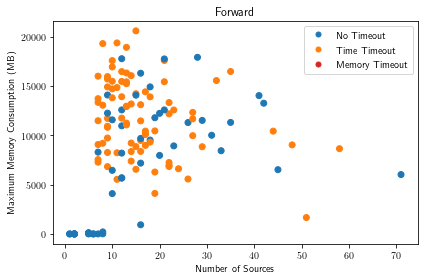

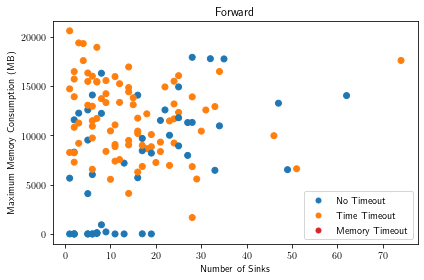

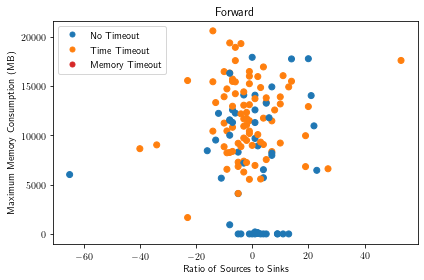

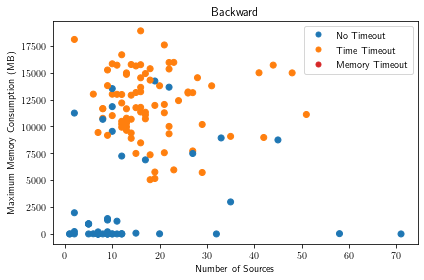

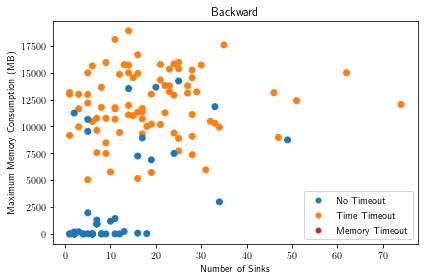

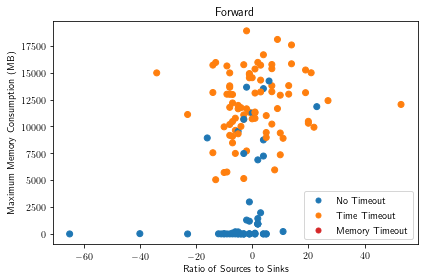

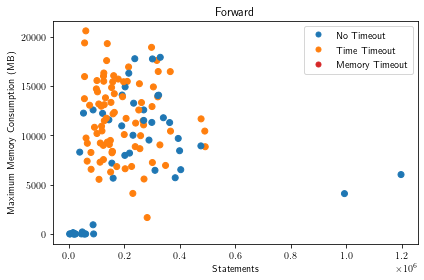

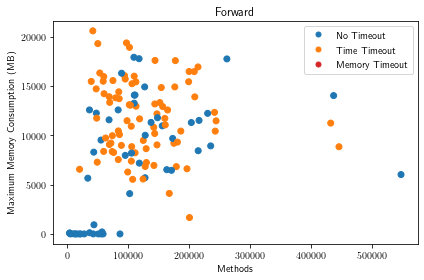

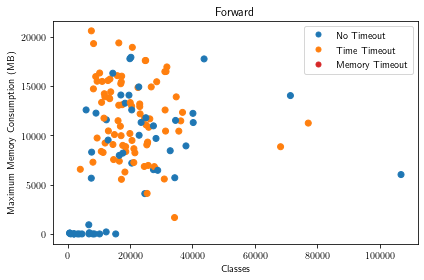

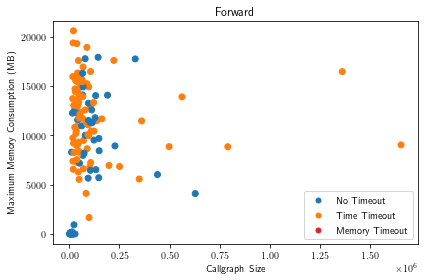

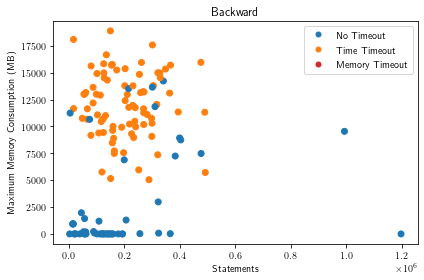

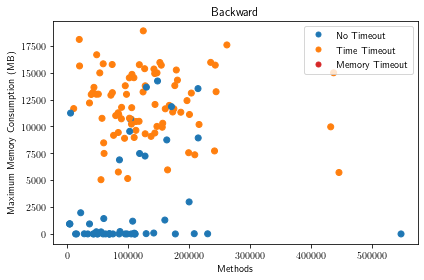

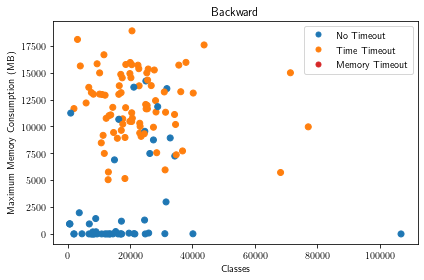

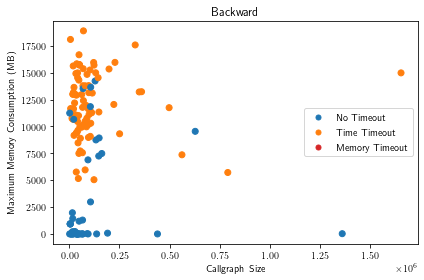

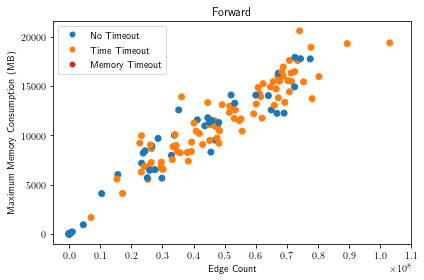

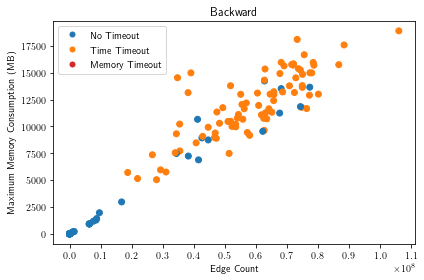

In [5]:
# Per Sources/Sinks
blue_dot = mlines.Line2D([], [], color='#1f77b4', marker='.', linestyle='None',
                          markersize=10, label='No Timeout')
orange_dot = mlines.Line2D([], [], color='#ff7f0e', marker='.', linestyle='None',
                          markersize=10, label='Time Timeout')
red_dot = mlines.Line2D([], [], color='#d62728', marker='.', linestyle='None',
                          markersize=10, label='Memory Timeout')
handles = [blue_dot, orange_dot, red_dot]

xsources = []
xsinks = []
xstmts = []
xratio = []
xclasses = []
xmethods = []
xcg = []
xedgesfw = []
xedgesbw = []
datafw = []
cfw = []
databw = []
cbw = []
for name, app in apps.items():
    if not app.isMemValid():
        continue
        
    for run in app.runsSMP:
        if run.direction == Direction.ForwardsSMP:
            datafw.append(run.maxMemPrecise)
            xsources.append(app.sources)
            xsinks.append(app.sinks)
            xstmts.append(app.statements)
            xratio.append(app.sinks - app.sources)
            xclasses.append(app.classes)
            xmethods.append(app.methods)
            xcg.append(app.cgsize)
            c = runToColor(run)
            cfw.append(runToColor(run))
            xedgesfw.append(run.absCountInfoflow + run.absCountAlias)
        elif run.direction == Direction.BackwardsSMP:
            databw.append(run.maxMemPrecise)
            cbw.append(runToColor(run))
            xedgesbw.append(run.absCountInfoflow + run.absCountAlias)


plt.figure()
plt.scatter(xsources, datafw, c=cfw)
plt.xlabel("Number of Sources")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-sources.pgf")       
plt.figure()
plt.scatter(xsinks, datafw, c=cfw)
plt.xlabel("Number of Sinks")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-sinks.pgf")
plt.figure()
plt.scatter(xratio, datafw, c=cfw)
plt.xlabel("Ratio of Sources to Sinks")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-ssratio.pgf")

plt.figure()
plt.scatter(xsources, databw, c=cbw)
plt.xlabel("Number of Sources")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-sources.pgf")
plt.figure()
plt.scatter(xsinks, databw, c=cbw)
plt.xlabel("Number of Sinks")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-sinks.pgf")
plt.figure()
plt.scatter(xratio, databw, c=cbw)
plt.xlabel("Ratio of Sources to Sinks")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-ssratio.pgf")

plt.figure()
plt.scatter(xstmts, datafw, c=cfw)
plt.xlabel("Statements")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-statements.pgf")
plt.figure()
plt.scatter(xmethods, datafw, c=cfw)
plt.xlabel("Methods")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-methods.pgf")
plt.figure()
plt.scatter(xclasses, datafw, c=cfw)
plt.xlabel("Classes")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-classes.pgf")
plt.figure()
plt.scatter(xcg, datafw, c=cfw)
plt.xlabel("Callgraph Size")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-cg.pgf")
plt.figure()
plt.scatter(xstmts, databw, c=cbw)
plt.xlabel("Statements")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-statements.pgf")
plt.figure()
plt.scatter(xmethods, databw, c=cbw)
plt.xlabel("Methods")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-methods.pgf")
plt.figure()
plt.scatter(xclasses, databw, c=cbw)
plt.xlabel("Classes")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-classes.pgf")
plt.figure()
plt.scatter(xcg, databw, c=cbw)
plt.xlabel("Callgraph Size")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-cg.pgf")

edgeMax = np.max(xedgesbw)
scale = np.arange(0, (round(edgeMax/10**7)+1) * 10**7, 10**7)
plt.figure()
plt.scatter(xedgesfw, datafw, c=cfw)
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Forward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-edges.pgf")

plt.figure()
plt.scatter(xedgesbw, databw, c=cbw)
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Maximum Memory Consumption (MB)")
plt.title("Backward")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-edges.pgf")



In [6]:
def filterZero(lst):
    res = []
    for e in lst:
        if e > 0:
            res.append(e)
    return res
        

MaxMemfw = []
MaxMembw = []
MaxMemWOfw = []
MaxMemWObw = []
avgMemfw = [[],[]]
avgMembw = [[],[]]
avgMemWOfw = [[],[]]
avgMemWObw = [[],[]]
absCountfw = [[], []]
absCountbw = [[], []]
absCountWOfw = [[], []]
absCountWObw = [[], []]

for name, app in apps.items():
    if not app.isMemValid():
        continue

    fw = -1
    fwAbs = -1
    bw = -1
    bwAbs = -1
    timeout = False
    for run in app.runsSMP:
        if run.direction == Direction.ForwardsSMP:
            fw = run.maxMemPrecise
            absCountfw[0].append(run.absCountInfoflow)
            absCountfw[1].append(run.absCountAlias)
            MaxMemfw.append(fw)
            avgMemfw[0].append(run.avgMemInfo)
            avgMemfw[1].append(run.avgMemAlias)
            if not run.timeTimeout:
                MaxMemWOfw.append(fw)
                absCountWOfw[0].append(run.absCountInfoflow)
                absCountWOfw[1].append(run.absCountAlias)
                avgMemWOfw[0].append(run.avgMemInfo)
                avgMemWOfw[1].append(run.avgMemAlias)
        elif run.direction == Direction.BackwardsSMP:
            bw = run.maxMemPrecise
            absCountbw[0].append(run.absCountInfoflow)
            absCountbw[1].append(run.absCountAlias)
            MaxMembw.append(bw)
            avgMembw[0].append(run.avgMemInfo)
            avgMembw[1].append(run.avgMemAlias)
            if not run.timeTimeout:
                MaxMemWObw.append(bw)
                avgMemWObw[0].append(run.avgMemInfo)
                avgMemWObw[1].append(run.avgMemAlias)
                absCountWObw[0].append(run.absCountInfoflow)
                absCountWObw[1].append(run.absCountAlias)


percentile = 85
print(f"Maximum Memory Consumption & ${round(np.average(MaxMemfw),2):.2f}MB$ & ${round(np.median(MaxMemfw),2):.2f}MB$ & ${round(np.percentile(MaxMemfw, percentile),2):.2f}MB$\\\\")
print("\\hline")
# print(f"Average Memory Consumption Infoflow & ${round(np.average(filterZero(avgMemfw[0])),2):.2f}MB$ & ${round(np.median(filterZero(avgMemfw[0])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMemfw[0]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Alias & ${round(np.average(filterZero(avgMemfw[1])),2):.2f}MB$ & ${round(np.median(filterZero(avgMemfw[1])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMemfw[1]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Total & ${round(np.average(filterZero(np.add(avgMemfw[0],avgMemfw[1]))),2):.2f}MB$ & ${round(np.median(filterZero(np.add(avgMemfw[0],avgMemfw[1])/2)),2):.2f}MB$ & ${round(np.percentile(filterZero(np.add(avgMemfw[0],avgMemfw[1])/2), percentile),2):.2f}MB$\\\\")
# print()
print(f"Maximum Memory Consumption & \\multirow{{2}}{{*}}{{${round(np.average(MaxMemWOfw),2):.2f}MB$}} & \\multirow{{2}}{{*}}{{${round(np.median(MaxMemWOfw),2):.2f}MB$}} & \\multirow{{2}}{{*}}{{${round(np.percentile(MaxMemWOfw, percentile),2):.2f}MB$}}\\\\")
print("Without Timeouts & & &\\\\")
# print("\\hline")
# print(f"Average Memory Consumption Infoflow & ${round(np.average(filterZero(avgMembw[0])),2):.2f}MB$ & ${round(np.median(filterZero(avgMembw[0])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMembw[0]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Alias & ${round(np.average(filterZero(avgMembw[1])),2):.2f}MB$ & ${round(np.median(filterZero(avgMembw[1])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMembw[1]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Total & ${round(np.average(filterZero(np.add(avgMembw[0],avgMembw[1]))),2):.2f}MB$ & ${round(np.median(filterZero(np.add(avgMembw[0],avgMembw[1])/2)),2):.2f}MB$ & ${round(np.percentile(filterZero(np.add(avgMembw[0],avgMembw[1])/2), percentile),2):.2f}MB$\\\\")

print()
print()

print(f"Maximum Memory Consumption & ${round(np.average(MaxMembw),2):.2f}MB$ & ${round(np.median(MaxMembw),2):.2f}MB$ & ${round(np.percentile(MaxMembw, percentile),2):.2f}MB$\\\\")
print("\\hline")
# print(f"Average Memory Consumption Infoflow & ${round(np.average(filterZero(avgMemWOfw[0])),2):.2f}MB$ & ${round(np.median(filterZero(avgMemWOfw[0])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMemWOfw[0]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Alias & ${round(np.average(filterZero(avgMemWOfw[1])),2):.2f}MB$ & ${round(np.median(filterZero(avgMemWOfw[1])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMemWOfw[1]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Total & ${round(np.average(filterZero(np.add(avgMemWOfw[0],avgMemWOfw[1]))),2):.2f}MB$ & ${round(np.median(filterZero(np.add(avgMemWOfw[0],avgMemWOfw[1])/2)),2):.2f}MB$ & ${round(np.percentile(filterZero(np.add(avgMemWOfw[0],avgMemWOfw[1])/2), percentile),2):.2f}MB$\\\\")
# print()
print(f"Maximum Memory Consumption & \\multirow{{2}}{{*}}{{${round(np.average(MaxMemWObw),2):.2f}MB$}} & \\multirow{{2}}{{*}}{{${round(np.median(MaxMemWObw),2):.2f}MB$}} & \\multirow{{2}}{{*}}{{${round(np.percentile(MaxMemWObw, percentile),2):.2f}MB$}}\\\\")
print("Without Timeouts & & &\\\\")
# print("\\hline")
# print(f"Average Memory Consumption Infoflow & ${round(np.average(filterZero(avgMemWObw[0])),2):.2f}MB$ & ${round(np.median(filterZero(avgMemWObw[0])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMemWObw[0]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Alias & ${round(np.average(filterZero(avgMemWObw[1])),2):.2f}MB$ & ${round(np.median(filterZero(avgMemWObw[1])),2):.2f}MB$ & ${round(np.percentile(filterZero(avgMemWObw[1]), percentile),2):.2f}MB$\\\\")
# print(f"Average Memory Consumption Total & ${round(np.average(filterZero(np.add(avgMemWObw[0],avgMemWObw[1]))),2):.2f}MB$ & ${round(np.median(filterZero(np.add(avgMemWObw[0],avgMemWObw[1])/2)),2):.2f}MB$ & ${round(np.percentile(filterZero(np.add(avgMemWObw[0],avgMemWObw[1])/2), percentile),2):.2f}MB$\\\\")

Maximum Memory Consumption & $10005.68MB$ & $10459.48MB$ & $15482.98MB$\\
\hline
Maximum Memory Consumption & \multirow{2}{*}{$7168.50MB$} & \multirow{2}{*}{$8090.91MB$} & \multirow{2}{*}{$13544.93MB$}\\
Without Timeouts & & &\\


Maximum Memory Consumption & $8326.27MB$ & $10008.52MB$ & $14539.64MB$\\
\hline
Maximum Memory Consumption & \multirow{2}{*}{$2594.34MB$} & \multirow{2}{*}{$27.30MB$} & \multirow{2}{*}{$8786.48MB$}\\
Without Timeouts & & &\\


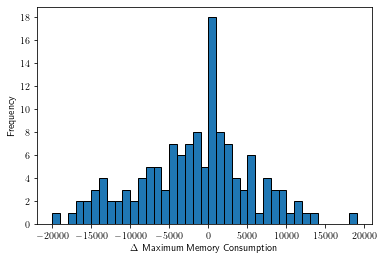

In [7]:
# Delta of each app with mem

xfw = []
datafw = []
cfw = []
xbw = []
databw = []
cbw = []

delta = []
deltat = []
for name, app in apps.items():
    if not app.isMemValid():
        continue
        
    d = 0
    dt = 0
    r1 = None
    r2 = None
    for run in app.runsSMP:
        if run.direction == Direction.ForwardsSMP:
            d -= run.maxMemPrecise
            dt -= run.dataflowTime
            r1 = run
        elif run.direction == Direction.BackwardsSMP:
            d += run.maxMemPrecise
            dt += run.dataflowTime
            r2 = run
            
#     if abs(d) > 399:
#         rel = app.sources / app.sinks
#         if d < 0:
#             ed1 = round(r1.infoflowEdges / r2.infoflowEdges)
#             ed2 = round(r1.aliasEdges / r2.aliasEdges)
#         else:
#             ed1 = round(r2.infoflowEdges / (1 if r1.infoflowEdges == 0 else r1.infoflowEdges))
#             ed2 = round(r2.aliasEdges / (1 if r1.aliasEdges == 0 else r1.aliasEdges))
# #         print(f"{name}: {d}s with {app.sources}:{app.sinks} and edge {ed1}:{ed2}")
    delta.append(d)
    
#     if np.sign(d) != np.sign(dt) and (dt > 10 or d > 100):
#         print("%s : %s" % (d, dt))

fig = plt.figure()
base = 1000
rounded = int(base * np.ceil(np.abs(delta).max()/base))
plt.hist(delta, bins=np.arange(-rounded, rounded, base), edgecolor='black')
plt.xlabel("$\\Delta$ Maximum Memory Consumption")
plt.ylabel("Frequency")
locs, labels = plt.yticks()
yint = np.arange(0, np.ceil(np.max(locs)), 2)
plt.yticks(yint)
plt.savefig(FIG_PATH + "memHist.pgf")